In [28]:
#import the libraries needed

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os



In [29]:
labels = pd.read_csv('C:\\Users\\hagraham\\OneDrive\\Northwestern\\458GeneralAI\\Project\\labels.csv')
labels['id'] = labels['id'].apply(lambda x: x + '.jpg')
labels = pd.DataFrame(labels)

In [30]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [31]:
#explore the data

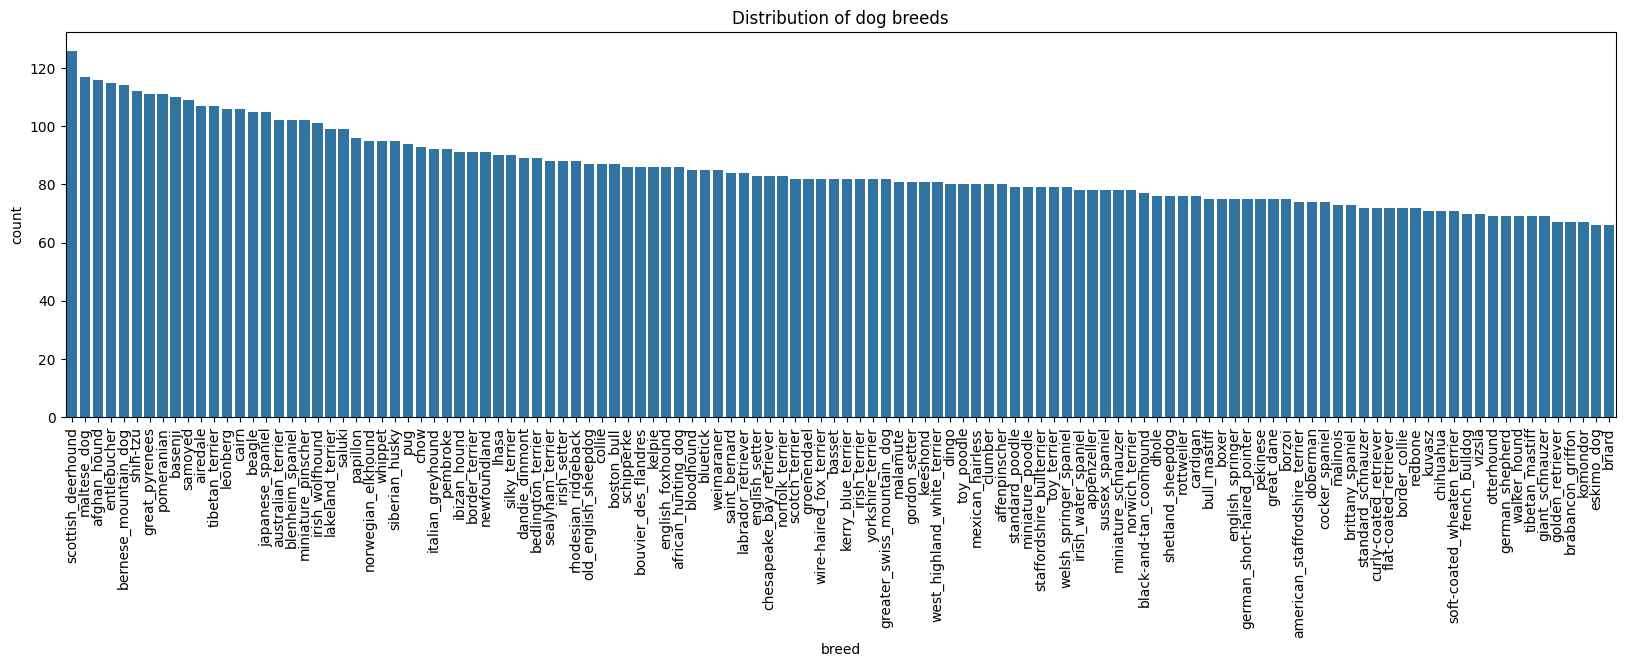

In [37]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)

# Define the order based on the frequency of each breed
order = labels['breed'].value_counts().index

# Use the order parameter in sns.countplot
sns.countplot(data=labels, x='breed', order=order)
plt.title('Distribution of dog breeds')
# Limit to top 10 dog breeds by count

plt.show()

In [34]:
breed_counts = labels['breed'].value_counts().reset_index()
breed_counts.columns = ['breed', 'count']
breed_counts = breed_counts.sort_values(by='count', ascending=False)
print(breed_counts)


                    breed  count
0      scottish_deerhound    126
1             maltese_dog    117
2            afghan_hound    116
3             entlebucher    115
4    bernese_mountain_dog    114
..                    ...    ...
115      golden_retriever     67
116     brabancon_griffon     67
117              komondor     67
118            eskimo_dog     66
119                briard     66

[120 rows x 2 columns]


In [35]:
breed_counts.describe()

,count
count,120.000000
mean,85.183333
std,13.298122
min,66.000000
25%,75.000000
50%,82.000000
75%,91.250000
max,126.000000


In [100]:
# breed_counts.to_csv('breed_counts.csv', index=False)

In [101]:
#split the data into training and testing sets

In [102]:
RANDOM_STATE = 42
train_df, test_df = train_test_split(labels, test_size=0.1, random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE)

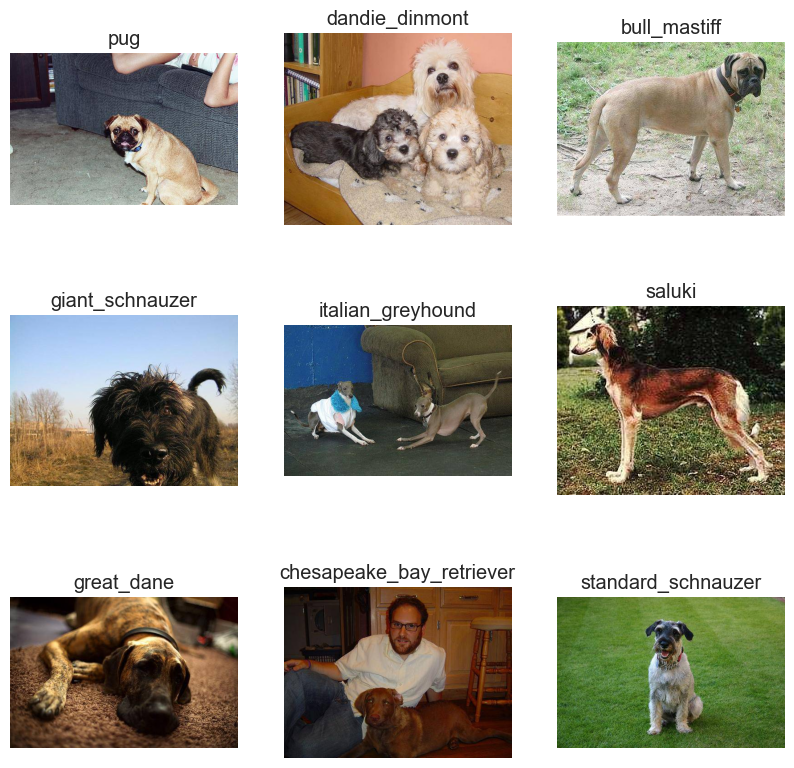

In [103]:
#check out a few sample images

# Assuming train_df is a DataFrame with image IDs and breeds
sample_images = train_df.sample(n=9)
plt.figure(figsize=(10,10))

# Directory containing the images
image_dir = r'C:\Users\hagraham\OneDrive\Northwestern\458GeneralAI\Project\train'

for ind, image_id in enumerate(sample_images['id']):
    # Construct the full path to the image file
    img_path = os.path.join(image_dir, f'{image_id}')  # Assuming images have .jpg extension
    img = cv2.imread(img_path)
    
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, ind + 1)
        plt.imshow(img)
        plt.title(sample_images.iloc[ind]['breed'])
        plt.axis('off')
    else:
        print(f"Error: Image {img_path} not loaded correctly.")

plt.show()

In [104]:
#understand image sizing

In [105]:
image_sizes = [Image.open(os.path.join(image_dir, f'{image_id}')).size for image_id in train_df['id']]

In [106]:
# Print some stats about image sizes
print(f'Min width: {min(sz[0] for sz in image_sizes)}')
print(f'Max width: {max(sz[0] for sz in image_sizes)}')
print(f'Min height: {min(sz[1] for sz in image_sizes)}')
print(f'Max height: {max(sz[1] for sz in image_sizes)}')

Min width: 97
Max width: 3264
Min height: 103
Max height: 2562


In [107]:
# constraints
SIZE = (350,350)
BATCH_SIZE = 32
NUM_CLASSES = len(labels['breed'].unique())
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.7
EPOCHS = 5

In [108]:
# rescale and batching the images

In [109]:
# Image processing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [110]:
# Data generators
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=image_dir, x_col='id', y_col='breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=image_dir, x_col='id', y_col='breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=image_dir, x_col='id', y_col='breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 7359 validated image filenames belonging to 120 classes.
Found 1023 validated image filenames belonging to 120 classes.
Found 1840 validated image filenames belonging to 120 classes.


In [111]:
# Base model
input_tensor = Input(shape=(SIZE[0], SIZE[1], 3))
base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model.trainable = False

In [112]:
# Output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Compile model
model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [113]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [114]:
# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples//BATCH_SIZE,
                    validation_steps=val_generator.samples//BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/5


C:\Users\hagraham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4182 - loss: 3.1536
Epoch 1: val_loss improved from inf to 0.62279, saving model to model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.4193 - loss: 3.1485 - val_accuracy: 0.8925 - val_loss: 0.6228
Epoch 2/5
  1/229 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.8750 - loss: 0.6739

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.62279 to 0.50558, saving model to model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8750 - loss: 0.6739 - val_accuracy: 0.9375 - val_loss: 0.5056
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8928 - loss: 0.5677
Epoch 3: val_loss improved from 0.50558 to 0.39606, saving model to model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 590s 3s/step - accuracy: 0.8928 - loss: 0.5674 - val_accuracy: 0.9084 - val_loss: 0.3961
Epoch 4/5
  1/229 ━━━━━━━━━━━━━━━━━━━━ 5:16 1s/step - accuracy: 0.9062 - loss: 0.3426
Epoch 4: val_loss did not improve from 0.39606
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9062 - loss: 0.3426 - val_accuracy: 0.9375 - val_loss: 0.4390
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9149 - loss: 0.3688
Epoch 5: val_loss improved from 0.39606 to 0.33758, saving model to model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.9149 - loss: 0.3688 - val_accuracy: 0.9106 - val_

In [115]:
# Evaluate model on test data
score = model.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9223 - loss: 0.3237
Test loss: 0.3221706449985504
Test accuracy: 0.9188660979270935


In [116]:
score

[0.3221706449985504, 0.9188660979270935]

In [133]:
# Print class indices
print("Class indices:", test_generator.class_indices)

# Print the first few class labels
print("Classes:", test_generator.classes[:10])

# Print the first few filenames
print("Filenames:", test_generator.filenames[:10])

# Print batch size
print("Batch size:", test_generator.batch_size)

# Print total number of samples
print("Total samples:", test_generator.n)

# Print image shape
print("Image shape:", test_generator.image_shape)

# Print data format
print("Data format:", test_generator.data_format)

Class indices: {'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired_poin

In [138]:
import numpy as np
import pandas as pd

# Get the predictions from the model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the class indices and corresponding class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Map predicted class indices to class names
y_pred_breeds = [class_names[idx] for idx in y_pred_classes]

# Get the actual class names from the test generator
y_true_breeds = [class_names[idx] for idx in test_generator.classes]

# Get the image IDs from the test generator
image_ids = test_generator.filenames

# Create a DataFrame with image ID, predicted class, actual class, and their indices
results_df = pd.DataFrame({
    'imageID': image_ids,
    'predicted_class': y_pred_breeds,
    'actual_class': y_true_breeds,
    'predicted_class_id': y_pred_classes,  # Add predicted class ID
    'actual_class_id': test_generator.classes  # Add actual class ID
})

# Display the DataFrame
print(results_df.head())

# Print the filename, predicted class ID, and actual class ID
for index, row in results_df.iterrows():
    print(f"Filename: {row['imageID']}, Predicted Class ID: {row['predicted_class_id']}, Actual Class ID: {row['actual_class_id']}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step
                                imageID predicted_class        actual_class  \
0  475171ec5847e4df41847e295b8cfca2.jpg         whippet         toy_terrier   
1  70c412a3ce894c617cbe707f24adbb82.jpg   affenpinscher        irish_setter   
2  c13427fc3db9194dac02b1721bd10fe4.jpg  great_pyrenees  scottish_deerhound   
3  00e9ed3fab1d2032603d1a90e557976f.jpg           dingo      english_setter   
4  7ba8102be491368fa69e832b3f1cec42.jpg            chow      great_pyrenees   

   predicted_class_id  actual_class_id  
0                 117              111  
1                   0               56  
2                  52               97  
3                  37               40  
4                  30               52  
Filename: 475171ec5847e4df41847e295b8cfca2.jpg, Predicted Class ID: 117, Actual Class ID: 111
Filename: 70c412a3ce894c617cbe707f24adbb82.jpg, Predicted Class ID: 0, Actual Class ID: 56
Filename: c13427fc3db9194dac02b1721bd10fe4.jpg, Predict

In [141]:
results_df.to_csv('model_predictions5Epoch.csv', index=False)

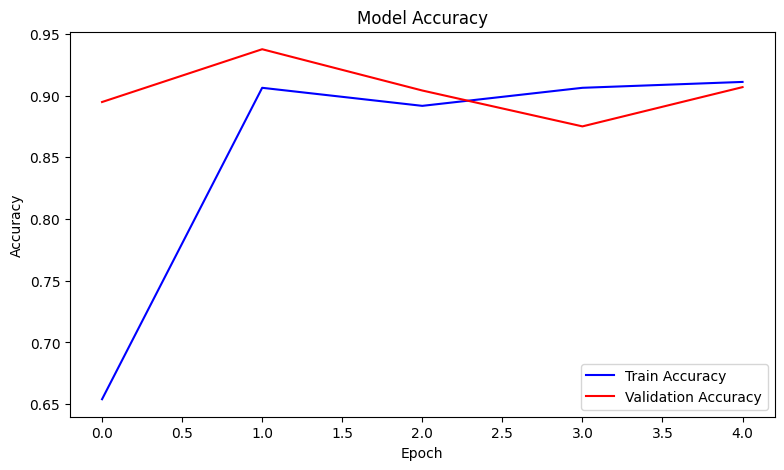

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower ')


# plt.tight_layout()
plt.show()

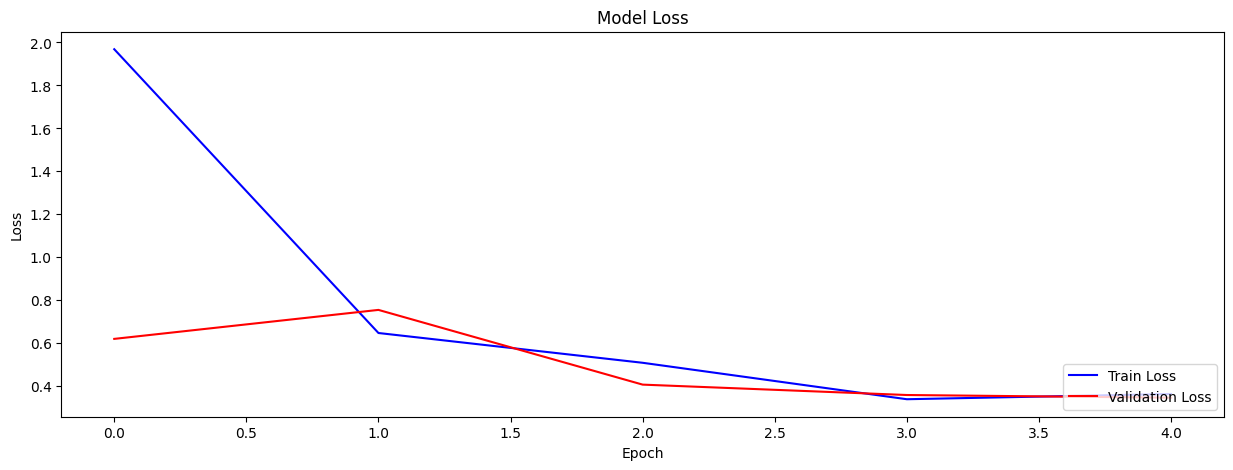

In [79]:
# Plot training & validation loss values

plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [80]:
# Save model accuracy results to CSV
accuracy_df = pd.DataFrame({
    'epoch': range(1, len(history.history['accuracy']) + 1),
    'train_accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
})
accuracy_df.to_csv('model_accuracy.csv', index=False)

# Save model loss results to CSV
loss_df = pd.DataFrame({
    'epoch': range(1, len(history.history['loss']) + 1),
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})
loss_df.to_csv('model_loss.csv', index=False)

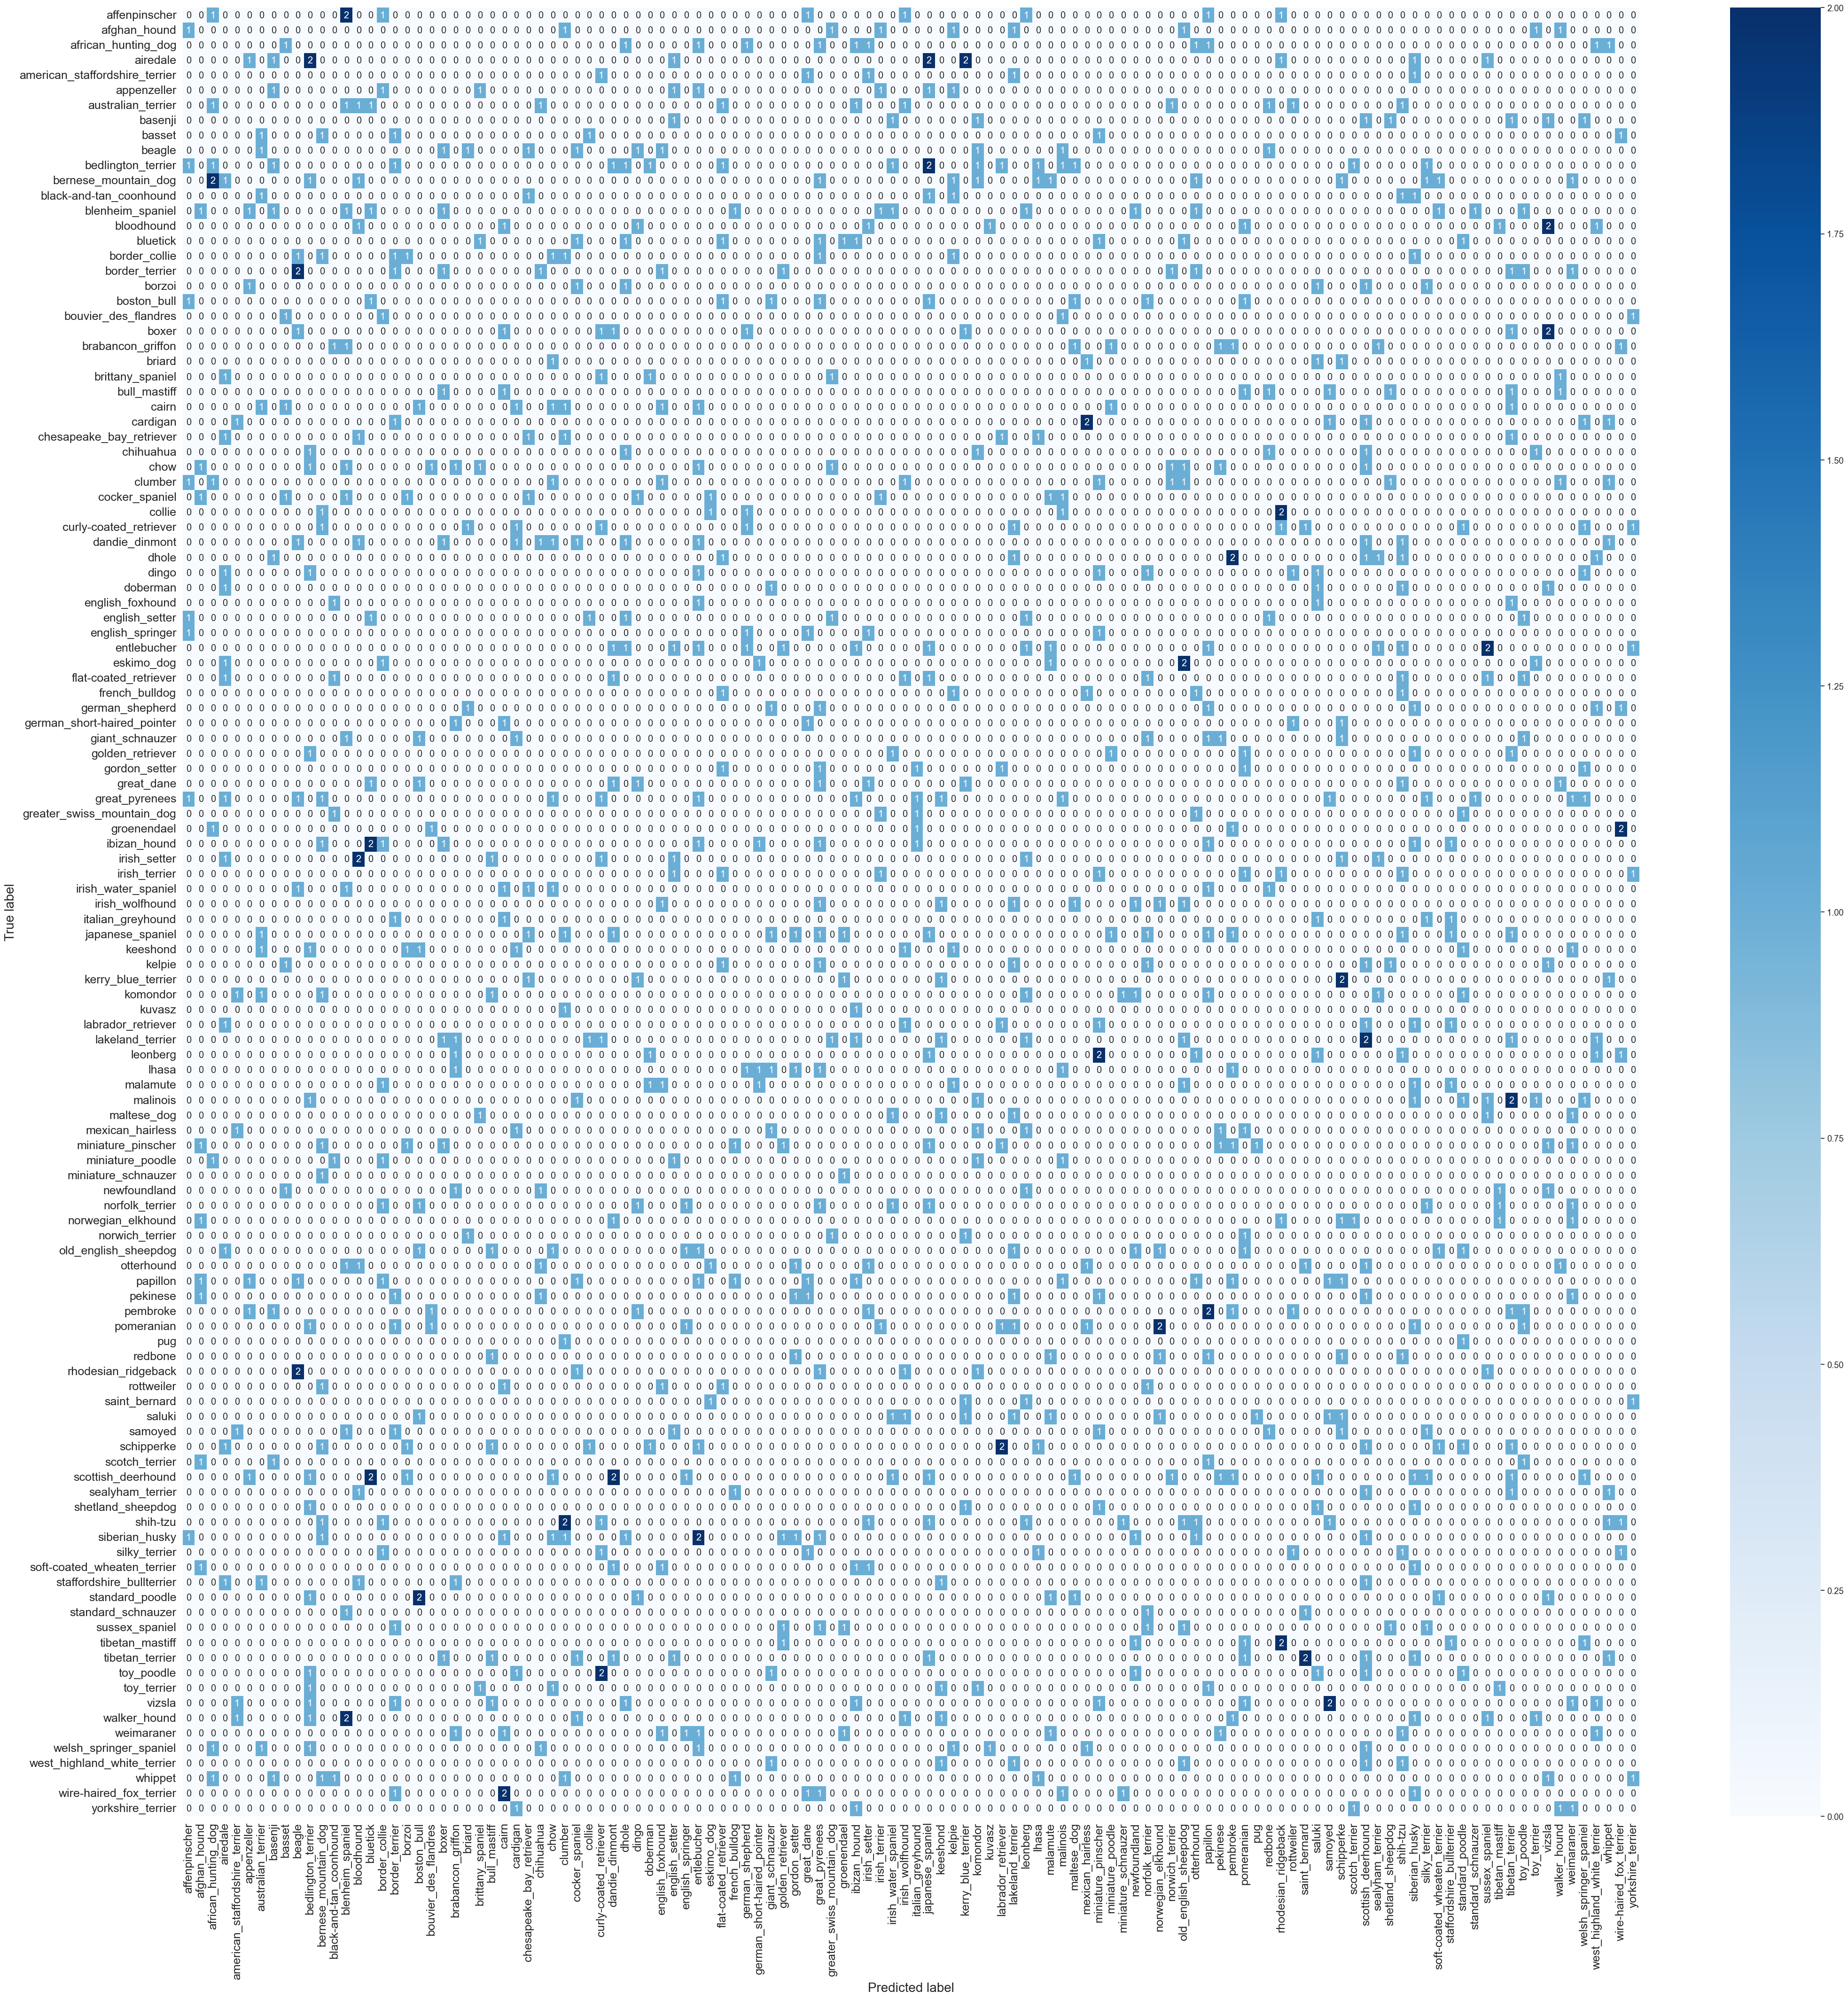

In [ ]:
# # Calculate confusion matrix
# confusion_mtx = confusion_matrix(test_generator.classes, y_pred_classes)

# # Normalize confusion matrix
# #confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# # Getting the list of dog breed names
# class_names = test_generator.class_indices.keys()

# # Plot the confusion matrix
# plt.figure(figsize=(50, 50))

# sns.set(font_scale=1.2)
# hm = sns.heatmap(confusion_mtx, annot=True, fmt=".0f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# # Improve the visibility of the labels
# hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18)
# hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)

# plt.ylabel('True label', fontsize=20)
# plt.xlabel('Predicted label', fontsize=20)
# plt.show()

In [ ]:
# # Print the confusion matrix
# print("Confusion Matrix:")
# print(confusion_mtx)

# # Print breed indices and their corresponding true positives and total images
# for breed in class_names:
#     breed_index = list(class_names).index(breed)
#     true_positives = confusion_mtx[breed_index, breed_index]
#     total_images = np.sum(confusion_mtx[breed_index, :])
#     print(f"Breed: {breed}, Index: {breed_index}, True Positives: {true_positives}, Total Images: {total_images}")

Confusion Matrix:
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Breed: affenpinscher, Index: 0, True Positives: 0, Total Images: 9
Breed: afghan_hound, Index: 1, True Positives: 0, Total Images: 9
Breed: african_hunting_dog, Index: 2, True Positives: 0, Total Images: 11
Breed: airedale, Index: 3, True Positives: 0, Total Images: 12
Breed: american_staffordshire_terrier, Index: 4, True Positives: 0, Total Images: 5
Breed: appenzeller, Index: 5, True Positives: 0, Total Images: 8
Breed: australian_terrier, Index: 6, True Positives: 0, Total Images: 12
Breed: basenji, Index: 7, True Positives: 0, Total Images: 8
Breed: basset, Index: 8, True Positives: 0, Total Images: 6
Breed: beagle, Index: 9, True Positives: 0, Total Images: 10
Breed: bedlington_terrier, Index: 10, True Positives: 0, Total Images: 18
Breed: bernese_mountain_dog, Index: 11, True Positives: 0, Total Images: 15
Breed: black-and-tan_coonhound, Index:

In [38]:
## re run model on 120 chosen images

In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the pre-trained model
model = load_model('model.keras')


In [26]:
import os
import numpy as np
import cv2
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained model
model = load_model('model.keras')

# Define the image size and other parameters
IMAGE_SIZE = (350, 350)
BATCH_SIZE = 32

# Load the labels from the CSV file
labels_path = r"C:\Users\hagraham\OneDrive\Northwestern\458GeneralAI\Project\labels.csv"
labels_df = pd.read_csv(labels_path)
labels_df['id'] = labels_df['id'].apply(lambda x: x + '.jpg')

# Create a data generator with labels to get class indices
image_dir = r"C:\Users\hagraham\OneDrive\Northwestern\458GeneralAI\Project\train"
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_dir,
    x_col='id',
    y_col='breed',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get the class indices and create a mapping from index to class name
class_indices = generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Rescale the image
    return image

# Function to make predictions on images in a folder
def predict_images_in_folder(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = preprocess_image(image_path)
            prediction = model.predict(image)
            predicted_class_index = np.argmax(prediction, axis=1)[0]
            predicted_class_name = class_names[predicted_class_index]
            results.append({
                'id': filename,
                'predicted_class_index': predicted_class_index,
                'predicted_class_name': predicted_class_name
            })
            
            print(f"Image: {filename}, Predicted Class Index: {predicted_class_index}, Predicted Class Name: {predicted_class_name}")
    df = pd.DataFrame(results)
    return df

# Example usage
folder_path = r"C:\Users\hagraham\OneDrive\Northwestern\458GeneralAI\Project\Code\subsetOFImages\resizedOnePerBreed"
CNNresults = predict_images_in_folder(folder_path)

Found 10222 validated image filenames belonging to 120 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
Image: 029202b0cf0b5d6d48c6ce7b432409ef.jpg, Predicted Class Index: 48, Predicted Class Name: giant_schnauzer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Image: 07192213791150248bfb5bbe6b0b0373.jpg, Predicted Class Index: 8, Predicted Class Name: basset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Image: 092c2cdbf133b201d7d56969bfbcc8f6.jpg, Predicted Class Index: 77, Predicted Class Name: miniature_schnauzer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Image: 0a77b9015c37f39c92b5399dc29da97c.jpg, Predicted Class Index: 57, Predicted Class Name: irish_terrier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Image: 0a9f8f6543d0b33fe9474035dd5323ef.jpg, Predicted Class Index: 23, Predicted Class Name: briard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Image: 0b346cec75418439f13eabdc7e96f33a.jpg, Predicted Class Index: 16, Predicted Class Name: border_collie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Image: 0e1ac042292a573ec

In [25]:
CNNresults.to_csv('extraTwoCNNresults.csv', index=False)